<a href="https://colab.research.google.com/github/wladrod/Aprendizaje-Automatico-2022/blob/master/notebooks/23-RedNeuronalConvolucional_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
    <h1>Tema 4: Redes Neuronales Convolucionales</h1>
    <h1>Clasificación de los Digitos MNIST</h1>
    <br>
    <h5>Prof. Wladimir Rodriguez</h5>
    <h5>wladimir@ula.ve</h5>
    <h5>Departamento de Computación</h5>
</center>

## Lo que vamos a cubrir

Vamos a aplicar el flujo de trabajo de PyTorch a la visión artificial.

<img src='../figuras/PyTorch_Flujo_Trabajo.png' />

Específicamente, vamos a cubrir:

| **Tema** | **Contenido** |
| ----- | ----- |
| **0. Librerías de visión artificial en PyTorch** | PyTorch tiene un conjunto de librerías integradas para la visión por computadora, vamos a verlas. |
| **1. Configure el código agnóstico del dispositivo para modelos futuros** | Es una buena práctica escribir código independiente del dispositivo, así que vamos a configurarlo. |
| **2. Cargar datos** | Para practicar la visión por computadora, comenzaremos con algunas imágenes de diferentes prendas de [MNIST](https://github.com/zalandoresearch/mnist). |
| **3. Preparar datos** | Tenemos algunas imágenes, carguémoslas con un [PyTorch `DataLoader`](https://pytorch.org/docs/stable/data.html) para poder usarlas con nuestro ciclo de entrenamiento. |
| **4. Modelo: Construcción de un modelo de Red Neuronal Convolucional (CNN)** | Aquí crearemos un modelo de clasificación de varias clases para aprender patrones en los datos, también elegiremos una **función de pérdida**, un **optimizador** y construiremos un **ciclo de entrenamiento**. |
| **5. Hacer predicciones y evaluar el modelo** | Hagamos algunas predicciones sobre imágenes aleatorias y evaluemos nuestro mejor modelo. |
| **6. Elaboración de una matriz de confusión** | Una matriz de confusión es una excelente manera de evaluar un modelo de clasificación, veamos cómo podemos hacer uno. |
| **7. Guardar y cargar el modelo** | Como es posible que queramos usar nuestro modelo para más adelante, guardémoslo y asegurémonos de que se cargue correctamente. |

## 0. Librerías de visión artificial en PyTorch

Antes de comenzar a escribir código, hablemos de algunas bibliotecas de visión por computadora de PyTorch que debe conocer.

| Módulo PyTorch | ¿Qué hace? |
| ----- | ----- |
| [`torchvision`](https://pytorch.org/vision/stable/index.html) | Contiene conjuntos de datos, arquitecturas de modelos y transformaciones de imágenes que se utilizan a menudo para problemas de visión artificial. |
| [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) | Aquí encontrará muchos ejemplos de conjuntos de datos de visión por computadora para una variedad de problemas, desde clasificación de imágenes, detección de objetos, subtítulos de imágenes, clasificación de videos y más. También contiene [una serie de clases base para crear conjuntos de datos personalizados](https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets). |
| [`torchvision.models`](https://pytorch.org/vision/stable/models.html) | Este módulo contiene arquitecturas de modelos de visión por computadora de buen rendimiento y de uso común implementadas en PyTorch, puede usarlas con sus propios problemas. |
| [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) | A menudo, las imágenes deben transformarse (convertirse en números/procesarse/aumentarse) antes de usarse con un modelo; las transformaciones de imágenes comunes se encuentran aquí. |
| [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) | Clase de conjunto de datos base para PyTorch. |
| [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#module-torch.utils.data) | Crea un iteralbe de Python sobre un conjunto de datos (creado con `torch.utils.data.Dataset`). |

> **Nota:** Las clases `torch.utils.data.Dataset` y `torch.utils.data.DataLoader` no son solo para la visión por computadora en PyTorch, son capaces de manejar muchos tipos diferentes de datos.

Ahora que hemos cubierto algunas de las librerías de visión por computadora de PyTorch más importantes, importemos las dependencias relevantes.

### Importar librerías

In [16]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torch.utils.data as data
import matplotlib.pyplot as plt

import numpy as np
torchvision.__version__, torch.__version__, np.__version__

('0.20.0+cu118', '2.5.0+cu118', '1.26.4')

## 1.0 Fijar dispositivo GPU o CPU

In [17]:
# Fijar dispositivo GPU o CPU
if torch.backends.mps.is_available():
    dispositivo = 'mps'
elif torch.cuda.is_available():
    dispositivo = "cuda"
else: "cpu"
dispositivo

'cuda'

## 2.0 Cargar los datos

Para comenzar a trabajar en un problema de visión por computadora, obtengamos un conjunto de datos de visión por computadora.

Vamos a empezar con MNIST.

La base de datos MNIST (base de datos del Instituto Nacional Modificado de Estándares y Tecnología) es una gran colección de dígitos escritos a mano. Tiene un conjunto de entrenamiento de 60.000 ejemplos y un conjunto de prueba de 10.000 ejemplos. Es un subconjunto de una base de datos especial 3 del NIST (dígitos escritos por empleados de la Oficina del Censo de Estados Unidos) y una base de datos especial 1 (dígitos escritos por estudiantes de secundaria) más grandes que contienen imágenes monocromáticas de dígitos escritos a mano. Los dígitos han sido normalizados en tamaño y centrados en una imagen de tamaño fijo. Las imágenes originales en blanco y negro (binivel) del NIST se normalizaron en tamaño para caber en un cuadro de 20x20 píxeles conservando su relación de aspecto. Las imágenes resultantes contienen niveles de gris como resultado de la técnica de suavizado utilizada por el algoritmo de normalización. las imágenes se centraron en una imagen de 28x28 calculando el centro de masa de los píxeles y trasladando la imagen para colocar este punto en el centro del campo de 28x28.

<img src='../figuras/MNIST.png' />

`PyTorch` tiene un montón de conjuntos de datos comunes de visión por computadora almacenados en `torchvision.datasets`.

Incluyendo MNIST en `torchvision.datasets.MNIST()`.

Para descargarlo, proporcionamos los siguientes parámetros:

- `root: str`: ¿a qué carpeta desea descargar los datos?
- `train: Bool`: ¿quieres la data de entrenamiento o la deprueba?
- `download: Bool`: ¿deberían descargarse los datos?
- `transform: torchvision.transforms` - ¿Qué transformaciones le gustaría hacer en los datos?
- `target_transform`: también puede transformar los objetivos (etiquetas) si lo desea.


Muchos otros conjuntos de datos en `torchvision` tienen estas opciones de parámetros.

In [18]:
# Bajar la data de entrenamiento 
datos_entrenamiento = datasets.MNIST(
    root='../datos/',
    download=True, 
    train=True, 
    transform=transforms.ToTensor())

# Bajar la data de prueba
datos_prueba = datasets.MNIST(
    root='../datos/',
    download=True, 
    train=False, 
    transform=transforms.ToTensor())

In [19]:
PROPORCION_VALIDACION = 0.9

n_ejemplos_entrenamiento = int(len(datos_entrenamiento) * PROPORCION_VALIDACION)
n_ejemplos_validacion = len(datos_entrenamiento) - n_ejemplos_entrenamiento

In [20]:
datos_entrenamiento, datos_validacion = data.random_split(datos_entrenamiento,
                                           [n_ejemplos_entrenamiento, n_ejemplos_validacion])

In [21]:
imagen, etiqueta = datos_entrenamiento[0]
imagen, etiqueta

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.2471, 0.4745, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0118, 0.5490, 0.9647, 

### 2.1 Formas de entrada y salida de un modelo de visión artificial

Tenemos un gran tensor de valores (la imagen) que conduce a un solo valor para el objetivo (la etiqueta).

Veamos la forma de la imagen.

In [22]:
# Cuál es la forma de la imagen
imagen.shape

torch.Size([1, 28, 28])

La forma del tensor de imagen es [1, 28, 28] o más específicamente:
```
[canales_color=1, alto=28, ancho=28]
```
Tener `canales_color=1` significa que la imagen está en escala de grises.

Si `canales_color=3`, la imagen viene en valores de píxeles para rojo, verde y azul (esto también se conoce como [modelo de color RGB](https://en.wikipedia.org/wiki/RGB_color_model)).

In [23]:
# Cuál es el número de ejemplos?
len(datos_entrenamiento), len(datos_validacion), len(datos_prueba)

(54000, 6000, 10000)

Así que tenemos 54000 muestras de entrenamiento, 6000 muestras de validación y 10 000 muestras de prueba.

¿Qué clases hay?

Podemos encontrarlos a través del atributo `.classes`.

In [24]:
# Ver las clases
nombre_clases = datos_entrenamiento.dataset.classes
nombre_clases

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Parece que estamos tratando con 10 tipos diferentes de digitos.

Debido a que estamos trabajando con 10 clases diferentes, significa que nuestro problema es **clasificación multiclase**.

Visualicemos.

### 2.2 Visualizar los datos

Forma de la imagen: torch.Size([1, 28, 28])


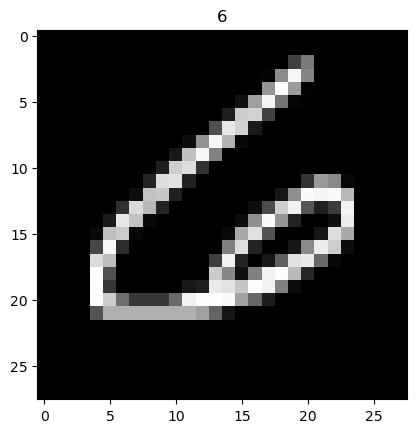

In [25]:
import matplotlib.pyplot as plt
imagen, etiqueta = datos_entrenamiento[0]
print(f"Forma de la imagen: {imagen.shape}")
plt.imshow(imagen.squeeze(), cmap='gray')
plt.title(etiqueta);

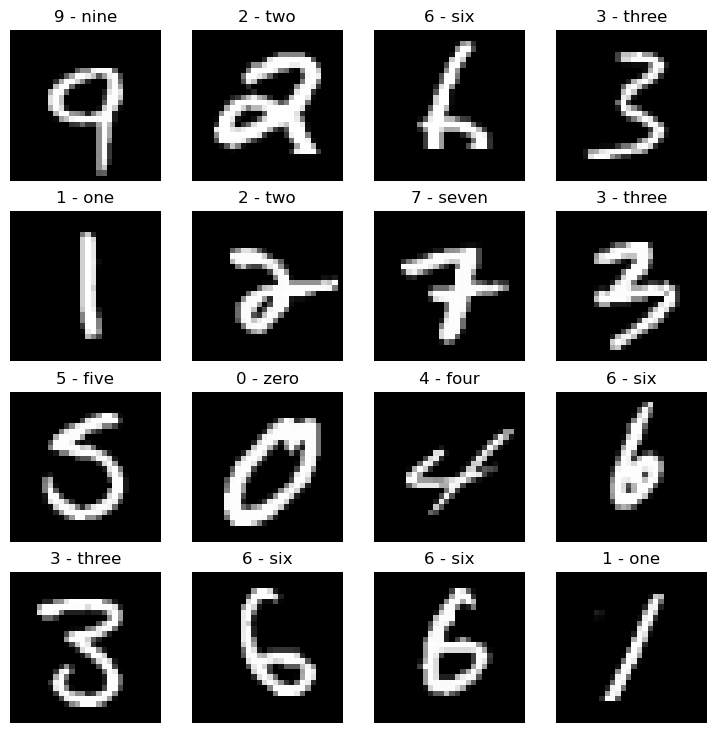

In [26]:
# Graficar mas imagenes
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
filas, columnas = 4, 4
for i in range(1, filas * columnas + 1):
    index_aleatorio = torch.randint(0, len(datos_entrenamiento), size=[1]).item()
    imgagen, etiqueta = datos_entrenamiento[index_aleatorio]
    fig.add_subplot(filas, columnas, i)
    plt.imshow(imgagen.squeeze(), cmap="gray")
    plt.title(nombre_clases[etiqueta])
    plt.axis(False);

## 3. Preparar DataLoader

Ahora tenemos un conjunto de datos listo para funcionar.

El siguiente paso es prepararlo con un `torch.utils.data.DataLoader` o `DataLoader` para abreviar.

El `DataLoader` hace lo siguiente:

- Ayuda a cargar datos a un modelo. Para entrenamiento y para inferencia.
- Convierte un gran `Dataset` en un Python iterable de fragmentos más pequeños.
- Estos fragmentos más pequeños se denominan *lotes* o *mini lotes* y se pueden configurar mediante el parámetro `batch_size`.
  - ¿Por qué hacer esto?
  - Porque es más eficiente computacionalmente.
  - En un mundo ideal, podría hacer el pase hacia adelante y hacia atrás en todos sus datos a la vez.
  - Pero una vez que comienza a usar conjuntos de datos realmente grandes, a menos que tenga una potencia computacional infinita, es más fácil dividirlos en lotes.
  - También le da al modelo más oportunidades para mejorar.
  - Con minilotes (pequeñas porciones de datos), el descenso de gradiente se realiza más a menudo por época (una vez por minilote en lugar de una vez por época).
  - ¿Cuál es un buen tamaño de lote?
  - 32 es un buen lugar para comenzar con una buena cantidad de problemas.
  - Pero dado que este es un valor que puede establecer (un hiperparámetro), puede probar diferentes tipos de valores, aunque generalmente se usan potencias de 2 con mayor frecuencia (por ejemplo, 32, 64, 128, 256, 512).
  
A continuación se crearan los `DataLoader` para nuestros conjuntos de entrenamiento y validación

In [27]:
tamaño_lote = 128

# Crear cargadores para los datos de entrenamiento y validación
cargador_entrenamiento = DataLoader(datos_entrenamiento,
                                    batch_size=tamaño_lote,
                                    shuffle=True)
cargador_validacion = DataLoader(datos_validacion, 
                                 batch_size=tamaño_lote,
                                 shuffle=False)
cargador_prueba = DataLoader(datos_prueba, 
                                 batch_size=tamaño_lote,
                                 shuffle=False)

print(f"Dataloaders: {cargador_entrenamiento, cargador_validacion, cargador_prueba}") 
print(f"Length of train dataloader: {len(cargador_entrenamiento)} batches of {tamaño_lote}")
print(f"Length of test dataloader: {len(cargador_validacion)} batches of {tamaño_lote}")
print(f"Length of test dataloader: {len(cargador_prueba)} batches of {tamaño_lote}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000015DE13F2B10>, <torch.utils.data.dataloader.DataLoader object at 0x0000015DE167B250>, <torch.utils.data.dataloader.DataLoader object at 0x0000015DDB79D090>)
Length of train dataloader: 422 batches of 128
Length of test dataloader: 47 batches of 128
Length of test dataloader: 79 batches of 128


In [28]:
# Que hay dentro del cargador de entrenamiento 
atributos_lote_entrenamiento, etiquetas_lote_entrenamiento = next(iter(cargador_entrenamiento))
atributos_lote_entrenamiento.shape, etiquetas_lote_entrenamiento.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

Y podemos ver que los datos permanecen sin cambios al verificar una sola muestra.

Tamaño de la imagen: torch.Size([1, 28, 28])
Etiqueta: 1, tamaño etiqueta: torch.Size([])


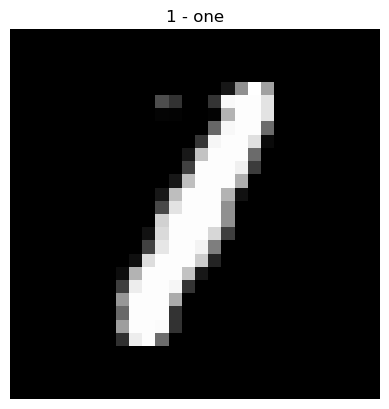

In [29]:
# Mostrar un ejemplo
torch.manual_seed(42)
index_aleatorio = torch.randint(0, len(atributos_lote_entrenamiento), size=[1]).item()
imagen, etiqueta = atributos_lote_entrenamiento[index_aleatorio], etiquetas_lote_entrenamiento[index_aleatorio]
plt.imshow(imagen.squeeze(), cmap="gray")
plt.title(nombre_clases[etiqueta])
plt.axis("Off");
print(f"Tamaño de la imagen: {imagen.shape}")
print(f"Etiqueta: {etiqueta}, tamaño etiqueta: {etiqueta.shape}")

## 4.0 Construir el modelo como una Red Neuronal Convolucional en PyTorch

Vamos a crear una [Red Neuronal Convolucional](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN o ConvNet).

Las CNN son conocidas por sus capacidades para encontrar patrones en datos visuales.

El modelo de CNN que vamos a usar se conoce como TinyVGG del sitio web [CNN Explainer](https://poloclub.github.io/cnn-explainer/).

Sigue la estructura típica de una red neuronal convolucional:

`Capa de entrada -> [Capa convolucional -> capa de activación -> capa de agrupación] -> Capa de salida`

Donde el contenido de `[Capa convolucional -> capa de activación -> capa de agrupación]` puede ampliarse y repetirse varias veces, según los requisitos.

Crearemos una CNN que replique el modelo del sitio web [CNN Explainer](https://poloclub.github.io/cnn-explainer/).

<img src='../figuras/cnn-explainer-model.png' />

In [30]:
class TinyVGG(nn.Module):
    """
    Arquitectura del modelo basada en TinyVGG: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, forma_entrada: int, numero_filtros: int, forma_salida: int):
        super().__init__()
        self.bloque_1 = nn.Sequential(
            nn.Conv2d(in_channels=forma_entrada, 
                      out_channels=numero_filtros, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=numero_filtros, 
                      out_channels=numero_filtros,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.bloque_2 = nn.Sequential(
            nn.Conv2d(numero_filtros, numero_filtros, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(numero_filtros, numero_filtros, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.clasificador = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=numero_filtros*7*7, 
                      out_features=forma_salida)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.bloque_1(x)
        x = self.bloque_2(x)
        x = self.clasificador(x)
        return x

In [31]:
torch.manual_seed(42)
modelo = TinyVGG(forma_entrada=1, 
    numero_filtros=30, 
    forma_salida=len(nombre_clases)).to(dispositivo)
modelo

TinyVGG(
  (bloque_1): Sequential(
    (0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bloque_2): Sequential(
    (0): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clasificador): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1470, out_features=10, bias=True)
  )
)

### 4.1 Definir funciones `paso_entrenamiento()` y  `paso_validacion()`

In [32]:
def paso_entrenamiento(modelo, 
             dataloader,
             perdida_fn, 
             optimizador):
    # Colocar modelo en modo entrenamiento
    modelo.train()
    
    # Inicializar valores de perdida y exactitud del entrenamiento
    perdida_entrenamiento, exactitud_entrenamiento = 0, 0
    
    # Iterar sobre los lotes del DataLoader
    for imagenes, etiquetas in dataloader:
        # Enviar datos al dispositivo
        imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
        
        # 1. Propagar hacia adelante los datos de entrenamiento usando el método forward()
        salida = modelo(imagenes)
        
        # 2. Calcule la pérdida (qué tan diferentes son las predicciones de nuestros modelos con respecto a la verdad del terreno)
        perdida = perdida_fn(salida, etiquetas)
        perdida_entrenamiento += perdida.item() 
        
        # 3. Colocar a cero los gradientes del optimizador
        optimizador.zero_grad()
        
        # 4. Propagación hacia atrás
        perdida.backward()
        
        # 5. Realizar paso de optimización
        optimizador.step()
        
        # Calcular y acumular la exactitud sobre todos los lotes
        clase_predicha = torch.argmax(torch.softmax(salida, dim=1), dim=1)
        exactitud_entrenamiento += (clase_predicha == etiquetas).sum().item()/len(salida)
    
    # Ajustar métricas para obtener un promedio de la perdida y la exactitud por lote
    perdida_entrenamiento /= len(dataloader)
    exactitud_entrenamiento /= len(dataloader)
    
    return perdida_entrenamiento, exactitud_entrenamiento

In [33]:
def paso_validacion(modelo,
            dataloader,
            perdida_fn):
        
    # Colocar el modelo en modo evaluación
    modelo.eval()

    # Inicializar valores de perdida y exactitud de la validación
    perdida_validacion, exactitud_validacion = 0, 0
    
    # Iniciar el manejador de contexto para inferencia
    with torch.inference_mode():
        # Iterar sobre los lotes del DataLoader
        for imagenes, etiquetas in dataloader:
            # Enviar datos al dispositivo
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            
            # 1. Propagar hacia adelante los datos de entrenamiento usando el método forward()
            salida = modelo(imagenes)
            
            # 2. Calcular y acumular la pérdida
            perdida = perdida_fn(salida, etiquetas)
            perdida_validacion += perdida.item()
            
            # 3. Calcular y acumular la exactitud
            clases_predicha = salida.argmax(dim=1)
            exactitud_validacion += ((clases_predicha == etiquetas).sum().item()/len(salida))
            
    # Ajustar métricas para obtener un promedio de la perdida y la exactitud por lote
    perdida_validacion /= len(dataloader)
    exactitud_validacion /= len(dataloader)
    
    return perdida_validacion, exactitud_validacion
  

### 4.2 Crear una función `entrenar()` para combinar `paso_entrenamiento()` y `paso_validacion()`

Ahora necesitamos una manera de juntar nuestras funciones `paso_entrenamiento()` y `paso_validacion()`.

Para hacerlo, los empaquetaremos en una función `entrenar()`.

Esta función entrenará el modelo y lo evaluará.

Específicamente, será:
1. Tome un modelo, un 'DataLoader' para conjuntos de entrenamiento y prueba, un optimizador, una función de pérdida y para cuántas épocas realizar cada paso de entrenamiento y prueba.
2. Cree un diccionario de resultados vacío para los valores `perdida_entrenamiento`, `exactitud_entrenamiento`, `perdida_validacion` y `exactitud_validacion` (podemos llenarlo a medida que avanza el entrenamiento).
3. Iterrar las funciones de paso de prueba y entrenamiento por varias épocas.
4. Imprime lo que sucede al final de cada época.
5. Actualiza el diccionario de resultados vacío con las métricas actualizadas cada época.
6. Devolver los resultados

Para realizar un seguimiento de la cantidad de épocas por las que hemos pasado, importemos `tqdm` desde `tqdm.auto` ([`tqdm`](https://github.com/tqdm/tqdm) es una de las librerías más populares  de barra de progreso para Python y `tqdm.auto` decide automáticamente qué tipo de barra de progreso es mejor para su entorno informático, por ejemplo, Jupyter Notebook vs. Python script).

In [34]:
from tqdm.auto import tqdm

def entrenar(modelo: torch.nn.Module,
             cargador_entrenamiento: torch.utils.data.DataLoader, 
             cargador_evaluacion: torch.utils.data.DataLoader, 
             optimizador: torch.optim.Optimizer,
             perdida_fn: torch.nn.Module = nn.CrossEntropyLoss(),
             epocas: int = 5):
    
    mejor_perdida_evaluacion = float('inf')
    
    # 2. Crear diccionario vacio para los resultados
    resultados = {"perdida_entrenamiento": [],
        "exactitud_entrenamiento": [],
        "perdida_evaluacion": [],
        "exactitud_evaluacion": []
    }
    
    # 3. Iterar sobre los pasos de entrenamiento y prueba por un número de epocas
    for epoca in tqdm(range(epocas)):
        perdida_entrenamiento, exactitud_entrenamiento = paso_entrenamiento(modelo=modelo,
                                                                            dataloader=cargador_entrenamiento,
                                                                            perdida_fn=perdida_fn,
                                                                            optimizador=optimizador)
        perdida_evaluacion, exactitud_evaluacion = paso_validacion(modelo=modelo,
                                                                   dataloader=cargador_validacion,
                                                                   perdida_fn=perdida_fn)
        
        # 4. Imprimir que esta pasando
        print(
            f"Epoca: {epoca+1} | "
            f"perdida_entrenamiento: {perdida_entrenamiento:.4f} | "
            f"exactitud_entrenamiento: {exactitud_entrenamiento:.4f} | "
            f"perdida_evaluación: {perdida_evaluacion:.4f} | "
            f"exactitud_evaluación: {exactitud_evaluacion:.4f}"
        )

        if perdida_evaluacion < mejor_perdida_evaluacion:
            mejor_perdida_evaluacion = perdida_evaluacion
            torch.save(modelo.state_dict(), 'mejor-modelo.pt')

        # 5. Actualizar el diccionario de resultados
        resultados["perdida_entrenamiento"].append(perdida_entrenamiento)
        resultados["exactitud_entrenamiento"].append(exactitud_entrenamiento)
        resultados["perdida_evaluacion"].append(perdida_evaluacion)
        resultados["exactitud_evaluacion"].append(exactitud_evaluacion)

    # 6. Retornar el diccionario de resultadoss al final de cada epoca
    return resultados

### 4.3 Entrenar y evaluar el modelo

Bien, bien, bien, tenemos todos los ingredientes que necesitamos para entrenar y evaluar nuestro modelo.

Es hora de juntar nuestro modelo `TinyVGG`, las funciones `DataLoader` y `train()` para ver si podemos construir un modelo capaz de discernir entre pizza, bistec y sushi.

Vamos a recrear `modelo` (no es necesario, pero lo haremos para completar) y luego llamamos a nuestra función `entrenar()` pasando los parámetros necesarios.

Para que nuestros experimentos sean rápidos, entrenaremos nuestro modelo durante **10 épocas** (aunque puede aumentar esto si lo desea).

En cuanto al **optimizador** y la **función de pérdida**, usaremos `torch.nn.CrossEntropyLoss()` (dado que estamos trabajando con datos de clasificación de clases múltiples) y `torch.optim.Adam( )` con una tasa de aprendizaje de `1e-3` respectivamente.

Para ver cuánto tardan las cosas, importaremos el método [`timeit.default_timer()`](https://docs.python.org/3/library/timeit.html#timeit.default_timer) de Python para calcular el tiempo de entrenamiento. .

In [35]:
# Fijar semilla del generador de números aleatorios
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Fijar el número de epocas
NUMERO_EPOCAS = 20

# Recrear una instancia de TinyVGG
modelo = TinyVGG(forma_entrada=1, 
                 numero_filtros=10, 
                 forma_salida=10).to(dispositivo)

# Fijar la funcion de perdida y el optimizados
perdida_fn = nn.CrossEntropyLoss()
optimizador = torch.optim.Adam(params=modelo.parameters(), lr=0.001)

# Inicializar el temporizador
from timeit import default_timer as timer 
tiempo_inicial = timer()

# Entrenar modelo  
modelo_resultados = entrenar(modelo=modelo,
                             cargador_entrenamiento=cargador_entrenamiento,
                             cargador_evaluacion=cargador_validacion,
                             optimizador=optimizador,
                             perdida_fn=perdida_fn,
                             epocas=NUMERO_EPOCAS)

# Finalizar el temporizador e imprimir cuanto tardo el entrenamiento
tiempo_final = timer()
print(f"Tiempo total de entrenamiento: {tiempo_final-tiempo_inicial:.3f} segundos")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoca: 1 | perdida_entrenamiento: 0.4552 | exactitud_entrenamiento: 0.8578 | perdida_evaluación: 0.1433 | exactitud_evaluación: 0.9562
Epoca: 2 | perdida_entrenamiento: 0.1135 | exactitud_entrenamiento: 0.9654 | perdida_evaluación: 0.0965 | exactitud_evaluación: 0.9712
Epoca: 3 | perdida_entrenamiento: 0.0839 | exactitud_entrenamiento: 0.9750 | perdida_evaluación: 0.0868 | exactitud_evaluación: 0.9737
Epoca: 4 | perdida_entrenamiento: 0.0701 | exactitud_entrenamiento: 0.9790 | perdida_evaluación: 0.0692 | exactitud_evaluación: 0.9782
Epoca: 5 | perdida_entrenamiento: 0.0615 | exactitud_entrenamiento: 0.9812 | perdida_evaluación: 0.0630 | exactitud_evaluación: 0.9804
Epoca: 6 | perdida_entrenamiento: 0.0546 | exactitud_entrenamiento: 0.9831 | perdida_evaluación: 0.0551 | exactitud_evaluación: 0.9835
Epoca: 7 | perdida_entrenamiento: 0.0491 | exactitud_entrenamiento: 0.9855 | perdida_evaluación: 0.0515 | exactitud_evaluación: 0.9840
Epoca: 8 | perdida_entrenamiento: 0.0445 | exactitud_en

### 4.4 Graficar las curvas de pérdidas del Modelo

Según los resultados del entrenamiento del `modelo`, pareciera tener una buena exactitud alrededor del 91%.

Pero podemos evaluarlo aún más trazando las **curvas de pérdida** del modelo.

**Las curvas de pérdida** muestran los resultados del modelo a lo largo del tiempo.

Y son una excelente manera de ver cómo se desempeña su modelo en diferentes conjuntos de datos (por ejemplo, entrenamiento y prueba).

Vamos a crear una función para trazar los valores en nuestro diccionario `modelo_resultados`.

In [36]:
# Ver las claves del diccionario modelo_resultados
modelo_resultados.keys()

dict_keys(['perdida_entrenamiento', 'exactitud_entrenamiento', 'perdida_evaluacion', 'exactitud_evaluacion'])

Tendremos que extraer cada una de estas claves y convertirlas en un gráfico.

In [37]:
def graficar_curvas_perdida(resultados):
    """Graficar las curvas de entrenamiento del diccionario de resultados.

    Argumentoss:
        resultadoss (dict): diccionario conteniendo una lista de valores containing list of valores.
            {"perdida_entrenamiento": [...],
             "exactitud_entrenamiento": [...],
             "perdida_evaluacion": [...],
             "exactitud_evaluacion": [...]}
    """
    
    # Obtener los valores de la perdida del diccionario de resultados (entrenamiento y validación)
    perdida = resultados['perdida_entrenamiento']
    perdida_validacion = resultados['perdida_evaluacion']

    # Obtener los valores de la exactitud del diccionario de resultados (entrenamiento y validación)
    exactitud = resultados['exactitud_entrenamiento']
    exactitud_validacion = resultados['exactitud_evaluacion']

    # Determinar el número de epocas
    epocas = range(len(resultados['perdida_entrenamiento']))

    # Configurar la gráfica 
    plt.figure(figsize=(15, 7))

    # Graficar la perdida
    plt.subplot(1, 2, 1)
    plt.plot(epocas, perdida, label='perdida_entrenamiento')
    plt.plot(epocas, perdida_validacion, label='perdida_validación')
    plt.title('Perdida')
    plt.xlabel('Epocas')
    plt.legend()

    # Graficar la exactitud
    plt.subplot(1, 2, 2)
    plt.plot(epocas, exactitud, label='exactitud_entrenamiento')
    plt.plot(epocas, exactitud_validacion, label='exactitud_validacion')
    plt.title('Exactitud')
    plt.xlabel('Epocas')
    plt.legend();

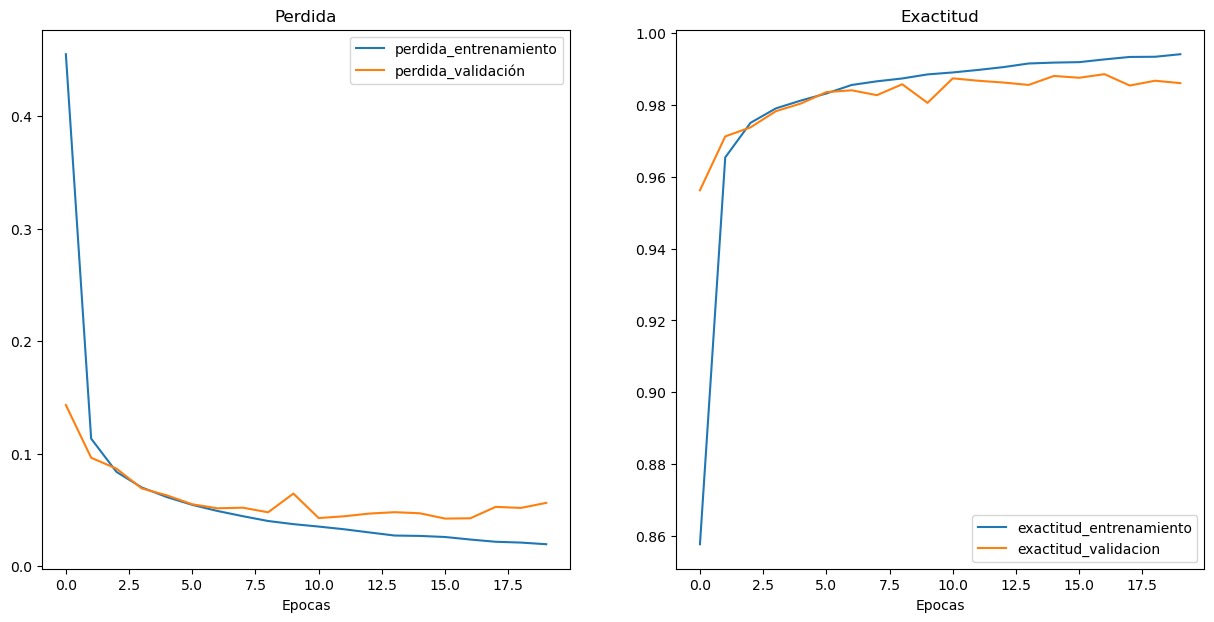

In [38]:
graficar_curvas_perdida(modelo_resultados)

## 4. Hacer y evaluar predicciones aleatorias


Para hacerlo, creemos una función `hacer_predicciones()` donde podemos pasar el modelo y algunos datos para que haga predicciones.

In [39]:
def hacer_predicciones(modelo: torch.nn.Module, data: list, dispositivo: torch.device = dispositivo):
    probabilidad_predicciones = []
    modelo.eval()
    with torch.inference_mode():
        for ejemplo in data:
            # Preparar ejemplo
            ejemplo = torch.unsqueeze(ejemplo, dim=0).to(dispositivo) # Agregar una dimensión extra y enviar ejemplo al dispositivo

            # propagar hacia adelante
            salida = modelo(ejemplo)

            # Obtener la probabilidda de la predicción (salida -> probabilidad predicción)
            probabilidad_prediccion = torch.softmax(salida.squeeze(), dim=0)

            # Sacar probabilidad_prediccion del GPU para siguientes calculos
            probabilidad_predicciones.append(probabilidad_prediccion.cpu())
            
    # Apilar las probabilidad_predicciones para convertir la lista en un tensor
    return torch.stack(probabilidad_predicciones)

In [40]:
import random
random.seed(42)
ejemplos_prueba = []
etiquetas_prueba = []
for ejemplo, etiqueta in random.sample(list(datos_prueba), k=9):
    ejemplos_prueba.append(ejemplo)
    etiquetas_prueba.append(etiqueta)

# Ver la forma del primer ejemplo y la etiqueta
print(f"Forma imagen ejemplo: {ejemplos_prueba[0].shape}\nEtiqueta imagen ejemplo: {etiquetas_prueba[0]} ({nombre_clases[etiquetas_prueba[0]]})")

Forma imagen ejemplo: torch.Size([1, 28, 28])
Etiqueta imagen ejemplo: 2 (2 - two)


Ahora podemos usar la función `hacer_predicciones()` para predecir sobre los `ejemplos_prueba`

In [41]:
# Hacer predicciones sobre el conjunto de prueba
modelo.load_state_dict(torch.load('mejor-modelo.pt'))
probabilidades_prediccion = hacer_predicciones(modelo=modelo,
                               data=ejemplos_prueba)

# Ver las probabilidades de las dos primeras predicciones
probabilidades_prediccion[:2]

C:\Users\kikez\AppData\Local\Temp\ipykernel_10148\2487418023.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelo.load_state_dict(torch.load('mejor-modelo.pt'))


tensor([[1.6446e-11, 1.4408e-07, 1.0000e+00, 1.6151e-09, 1.2605e-21, 3.5332e-17,
         3.5924e-15, 1.2829e-09, 4.6502e-08, 3.7879e-13],
        [3.8625e-09, 9.9577e-01, 9.1017e-06, 8.2503e-06, 1.2775e-03, 1.4332e-06,
         1.0445e-05, 4.6888e-05, 2.8345e-03, 4.1560e-05]])

¡Excelente!

Y ahora podemos pasar de las probabilidades de predicción a las etiquetas de predicción tomando `torch.argmax()` de la salida de la función de activación `torch.softmax()`.

In [42]:
# Convertir las probabilides de la predicción en las etiquetas usando argmax()
clases_predicha = probabilidades_prediccion.argmax(dim=1)
clases_predicha

tensor([2, 1, 2, 4, 6, 6, 4, 9, 1])

In [43]:
# Are our predictions in the same form as our test labels? 
etiquetas_prueba, clases_predicha

([2, 1, 2, 4, 6, 6, 4, 9, 1], tensor([2, 1, 2, 4, 6, 6, 4, 9, 1]))

Ahora nuestras clases pronosticadas están en el mismo formato que nuestras etiquetas de prueba, podemos comparar.
Ya que estamos tratando con datos de imágenes, vamos a visualizar las predicciones.

In [44]:
# Graficar predicciones
plt.figure(figsize=(9, 9))
filas = 3
columnas = 3
for i, ejemplo in enumerate(ejemplos_validacion):
  # Crear un subplot
  plt.subplot(filas, columnas, i+1)

  # Graficar la imagen objetivo
  plt.imshow(ejemplo.squeeze(), cmap="gray")

  # Encontrar la etiqueta de la predicción (en forma de texto, p.e. "Sandal")
  etiqueta_predicha = nombre_clases[clases_predicha[i]]

  # Encontrar la etiqueta real (en forma de texto, p.e. "T-shirt")
  etiqueta_real = nombre_clases[etiquetas_prueba[i]] 

  # Crear el titulo de la gráfica
  texto_titulo = f"Pred: {etiqueta_predicha} | Real: {etiqueta_real}"
  
  # Chequear si son iguales y cambiar color
  if etiqueta_predicha == etiqueta_real:
      plt.title(texto_titulo, fontsize=10, c="g") # texto verde si correcto
  else:
      plt.title(texto_titulo, fontsize=10, c="r") # texto rojo si incorrecto
  plt.axis(False);

NameError: name 'ejemplos_validacion' is not defined

<Figure size 900x900 with 0 Axes>

## 5. Elaboración de una matriz de confusión para una mejor evaluación de la predicción

Hay muchas diferentes métricas de evaluación que podemos usar para problemas de clasificación.

Uno de los más visuales es una [matriz de confusión](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/).

Una matriz de confusión le muestra dónde se confundió su modelo de clasificación entre predicciones y etiquetas verdaderas.

Para hacer una matriz de confusión, seguiremos tres pasos:
1. Hacer predicciones con el modelo entrenado, `modelo` (una matriz de confusión compara las predicciones con las etiquetas verdaderas).
2. Hacer una matriz de confusión usando [`torch.ConfusionMatrix`(https://torchmetrics.readthedocs.io/en/latest/references/modules.html?highlight=confusion#confusionmatrix).
3. Grafica la matriz de confusión usando [`mlxtend.plotting.plot_confusion_matrix()`(http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/).

Comencemos por hacer predicciones con nuestro modelo entrenado.

In [ ]:
# 1. Hacer predicciones con el modelo entrenado
predicciones = []
modelo.eval()
with torch.inference_mode():
  for imagen, etiqueta in tqdm(cargador_prueba, desc="Haciendo predicciones"):
    # Enviar datos al dispositivo
    imagen, etiqueta = imagen.to(dispositivo), etiqueta.to(dispositivo)
    # Realizar la propagación hacia adelante
    salida = modelo(imagen)
    # Convertir la salida a predicciones salida -> probabilidades predicción  -> etiquetas predicción
    prediccion = torch.softmax(salida.squeeze(), dim=0).argmax(dim=1)
    # Colocar las predicciones en el CPU para evaluación
    predicciones.append(prediccion.cpu())
# Concatenar lista de predicciones en un tensor
tensor_predicciones = torch.cat(predicciones)
correctos = torch.eq(datos_prueba.targets, tensor_predicciones)
print(f'Exactitud: {correctos.sum()/100:.2f}')

Ahora que tenemos predicciones, sigamos los pasos 2 y 3:

2. Crear una matriz de confusión usando [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/latest/references/modules.html?highlight=confusion#confusionmatrix).
3. Graficar la matriz de confusión usando [`mlxtend.plotting.plot_confusion_matrix()`](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/).

Primero necesitaremos asegurarnos de tener `torchmetrics` y `mlxtend` instalados (estas dos bibliotecas nos ayudarán a crear y visualizar una matriz de confusión).

> **Nota:** Si está utilizando Google Colab, la versión predeterminada de `mlxtend` instalada es 0.14.0 (a partir de marzo de 2022), sin embargo, para los parámetros de la función `plot_confusion_matrix()`, necesitamos 0.19.0 o superior.

In [ ]:
# Ver si existe torchmetrics, si no, instalarla.
try:
    import torchmetrics, mlxtend
    print(f"versión mlxtend: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend versión debe ser 0.19.0 o mayor"
except:
    !pip install -q torchmetrics -U mlxtend # <- Nota: si está utilizando Google Colab, esto puede requerir reiniciar la ejecución
    import torchmetrics, mlxtend
    print(f"versión mlxtend: {mlxtend.__version__}")

Con `torchmetrics` y `mlxtend` instalados, ¡hagamos una matriz de confusión!

Primero crearemos una instancia `torchmetrics.ConfusionMatrix` diciéndole con cuántas clases estamos tratando configurando `num_classes=len(nombre_clases)`.

Luego, crearemos una matriz de confusión (en formato de tensor) pasando a nuestra instancia las predicciones de nuestro modelo (`preds=tensor_predicciones`) y objetivos (`target=datos_prueba.targets`).

Finalmente, podemos graficar nuestra matriz de confusión usando la función `plot_confusion_matrix()` de `mlxtend.plotting`.

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Configurar una instancia de la matriz de confusión matrix y comparar predicciones con objetivos
matriz_confusion = ConfusionMatrix(task='multiclass', num_classes=len(nombre_clases))
tensor_matriz_confusion = matriz_confusion(preds=tensor_predicciones,
                                           target=datos_prueba.targets)

# 3. Graficar la matriz de the confusión
fig, ax = plot_confusion_matrix(
    conf_mat=tensor_matriz_confusion.numpy(), # matplotlib trabaja con NumPy 
    class_names=nombre_clases, # convertir etiquetas de fila y columna en nombre de clases
    figsize=(10, 7)
);

Podemos ver que nuestro modelo funciona bastante bien ya que la mayoría de los cuadrados oscuros están en la diagonal desde la parte superior izquierda hasta la parte inferior derecha (y el modelo ideal tendrá solo valores en estos cuadrados y 0 en todos los demás).
El modelo se "confunde" más en las clases que son similares, por ejemplo, prediciendo 

## 7. Guardar el modelo

Estamos contentos con las predicciones de nuestros modelos, así que guardémoslo en un archivo para que pueda usarse más tarde.

In [ ]:
from pathlib import Path

# 1. Crear un directorio para los modelos 
MODELOS_PATH = Path('../modelos')
MODELOS_PATH.mkdir(parents=True, exist_ok=True)

# 2. Crear path para el modelo 
MODELO_NOMBRE = "23-RNC_modelo_MNIST.pth"
MODELO_DIRECCION = MODELOS_PATH / MODELO_NOMBRE

# 3. Guardar el state_dict del modelo
print(f"Guardando modelo en: {MODELO_DIRECCION}")
torch.save(obj=modelo.state_dict(), # guardando state_dict() solo guarda los parámetros del modelo
           f=MODELO_DIRECCION)

### Cargar modelo y continuar entrenamiento

In [ ]:
# Instanciar una nueva instancia del modelo 
modelo_cargado = TinyVGG(forma_entrada=1,
                        numero_filtros=10,
                        forma_salida=10)

# Cargar el state dict del modelo
modelo_cargado.load_state_dict(torch.load(MODELO_DIRECCION))

# Colocar el modelo en el dispositivo destino (si los datos estan en el GPU, el modelo tiene que estar en el GPU para hacer predicciones)
modelo_cargado.to(dispositivo)

print(f"Modelo cargado:\n{modelo}")

### Formulas para calcular los tamaños de salida de las capas de convolución y *pooling* (agregación o reducción)

La formula que relaciona el tamaño de salida de la convolución con el tamaño de la entrada es:

$$ W = \lfloor \frac{W_{prev} - f + 2 \times relleno}{paso} \rfloor +1 $$

$$f = \text{número de filtros usados en la convolución}$$

La formula que relaciona el tamaño de salida del *pooling* con el tamaño de la entrada es:

$$ W = \lfloor \frac{W_{prev} - f}{paso} \rfloor +1 $$

$$f = \text{tamaño de la ventana de pooling}$$